# Betting on NBA

In [ ]:
#TO IMPROVE
# min à 0 lorsque joue pas
# Prendre en compte blessure top7 joueurs - flag nb match avec sans gros joueur
# Poids sur les derniers matchs
# https://www.espn.com/nba/injuries
# https://www.espn.com/nba/player/gamelog/_/id/3136195/karl-anthony-towns not recognise
# O'Neale  / Lonnie Walker IV  / Robert Williams problem

In [367]:
#pip install selenium
#pip install webdriver-manager
#pip install BeautifulSoup4

SyntaxError: invalid syntax (<ipython-input-367-779a1681d36c>, line 4)

In [135]:
import pandas as pd
import numpy as np
import re
import requests
import webbrowser
import seaborn as sns
import urllib.request, json 
from IPython.core.display import display, HTML
from itertools import chain
from datetime import date
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
#from selenium.webdriver.firefox.firefox_binary import FirefoxBinary
from selenium import webdriver
from datetime import datetime, date, timedelta
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
#driver = webdriver.Chrome("C:/Users/Valentin/Documents/Winamax/chromedriver")
driver = webdriver.Chrome(ChromeDriverManager().install())



====== WebDriver manager ======
Current google-chrome version is 95.0.4638
Get LATEST driver version for 95.0.4638
Driver [C:\Users\Valentin\.wdm\drivers\chromedriver\win32\95.0.4638.54\chromedriver.exe] found in cache


In [136]:
def get_page(special_match):
    driver.get(special_match)
    try:
        element = driver.find_element_by_class_name('banner-actions-container')
        element.click()
    except:
        do = "nothing"
        

    get_page(Page)

    ###### Get list of Games
    soup = BeautifulSoup(driver.page_source)

In [137]:
#Function Soup
def get_page(special_match):
    driver.get(special_match)
    try:
        element = driver.find_element_by_class_name('banner-actions-container')
        element.click()
    except:
        print("") 

############ Parameters
get_page("https://www.espn.com/nba/schedule/_/date/" + date.today().strftime("%Y%m%d"))
soup = BeautifulSoup(driver.page_source)

list_Pages = []
list_Players = []
for teams in soup.find(class_='schedule has-team-logos align-left').findAll(class_='team-name'):
    p = "https://www.espn.com/nba/team/schedule/_/name/" + teams['href'].replace("/nba/team/_/name/", "").split("/")[0] + "/seasontype/2"
    list_Pages.append(p)
    list_Players.append(p.replace("/schedule/", "/stats/").replace("/seasontype/1", ""))

#Shorten the list
#list_Pages = list_Pages[0:1]
#list_Players = list_Players[0:1]

In [138]:
d = pd.DataFrame()
print("------------- " + str(int(len(list_Pages)/2)) + " games" + " ------------")

###### Get_Page function
def get_page(special_match):
    driver.get(special_match)
    try:
        element = driver.find_element_by_class_name('banner-actions-container')
        element.click()
    except:
        do = "nothing"
            
for jj in range(len(list_Pages)):
    Page = list_Pages[jj]
    Players = list_Players[jj]
    if(((jj+1)%2)!=0):
        sufx = str(int(jj/2.0+1)) + " "
    else:
        sufx = "  "
    print(sufx + Page.replace("https://www.espn.com/nba/team/schedule/_/name/", "").replace("/seasontype/2", ""))

    ###### Game/Games
    #get_page(special_match)
    get_page(Page)

    ###### Get list of Games
    soup = BeautifulSoup(driver.page_source)
    list_games = []

    for hrefs in soup.find(class_='Table__TBODY').findAll(class_='AnchorLink', href=re.compile("gameId")):
        list_games.append(hrefs['href'].replace("/game/", "/boxscore/"))

    index_games = soup.prettify().split("DATE\n")[1].split("data-idx")
    index_games = int(index_games[len(index_games)-1].split('">\n ')[0].split('="')[1])
    list_games = list_games[0:index_games-1]

    get_page(Players)
    soup = BeautifulSoup(driver.page_source)

    list_href_players = []
    for href_players in soup.find(class_='Table__TBODY').findAll(class_='AnchorLink', href=re.compile("player/_/id/")):
        list_href_players.append(href_players['href'].replace("https://www.espn.com/nba/player/_/id/", ""))

    def filterOut2(x):return x.split('-')[1]
    list_href_players = list(map(filterOut2, list_href_players))
    list_href_players

    for games in list_games:
        get_page(games)
        soup = BeautifulSoup(driver.page_source)

        ############ Creation of the dataset
        for i in range(0, 2): #0 to 1 because two teams
            my_table = soup.findAll(class_='content desktop')[i]
            Team_finded = my_table.find(class_='team-name')

            #Team_finded = my_table.contents[1]
            if 1 == 1:
                my_table = my_table.find(class_='mod-data')

                table_data = []
                for row in my_table.findAll('tr'):
                    row_data = []    
                    URLs = []    
                    
                    for u in row.findAll("a"):
                        URLs.append(u["href"].replace("/player/_/id/","/player/gamelog/_/id/"))
                        
                    for cell in row.findAll('td'):
                        row_data.append(cell.text)
                        
                    row_data = list(chain.from_iterable([row_data, URLs]))
                    
                    if(len(row_data) > 0):
                        if(any(string in row_data[0].lower() for string in list_href_players)):
                            #print(row_data)
                            if(row_data[0] == "TEAM" or row_data[0] == "" or len(row_data[0])==1):
                                do = "nothing"
                            else:
                                if('DNP' in row_data[1] or 
                                   row_data[0] == "TEAM"):
                                    data_item = {"Player": row_data[0],
                                                  "Minutes": 0}
                                else:
                                    if(jj<10):
                                        num = "0" + str(jj)
                                    else:
                                        num = str(jj)
                                    
                                    if float(row_data[14])>=20: PT20 = 1
                                    else: PT20 = 0
                                    if float(row_data[14])>=25: PT25 = 1
                                    else: PT25 = 0
                                    if float(row_data[14])>=30: PT30 = 1
                                    else: PT30 = 0
                                            
                                    data_item = {"Player": row_data[0],#.Substring(0, input.FirstIndexOf(".")),
                                                  "Minutes": row_data[1],
                                                  "FG": row_data[2],
                                                  "3PT": row_data[3],
                                                  "FT": row_data[4],
                                                  "OREB": row_data[5],
                                                  "DREB": row_data[6],
                                                  "REB": row_data[7],
                                                  "AST": row_data[8],
                                                 #calculated columns
                                                  "PTS_REB_AST": float(row_data[14])+float(row_data[7])+float(row_data[8]),
                                                  "PTS_REB": float(row_data[14])+float(row_data[7]),
                                                  "PTS_AST": float(row_data[14])+float(row_data[8]),
                                                  "REB_AST": float(row_data[7])+float(row_data[8]),
                                                  "20PTS": PT20,
                                                  "25PTS": PT25,
                                                  "30PTS": PT30,
                                                  "STL": row_data[9],
                                                  "BLK": row_data[10],
                                                  "TO": row_data[11],
                                                  "PF": row_data[12],
                                                  "PlusMinus": row_data[13],
                                                  "PTS": row_data[14],
                                                  "Team": num + "_" + Page.replace("https://www.espn.com/nba/team/schedule/_/name/", "").replace("/seasontype/2", ""),
                                                  "team":any(string in row_data[0].lower() for string in list_href_players),
                                                  "URL": row_data[15]
                                    }
                            table_data.append(data_item)

                data = pd.DataFrame(table_data)[:-1]
                d = pd.concat([d,data])
                
                
d.dropna(subset = ["REB"], inplace=True)
d["3PT"] = d["3PT"].astype(str)
d = d.assign(TPTW = d['3PT'].map(lambda x: x.split('-')[0]))
d["TPTW"] = d["TPTW"].astype(int, errors = 'raise')
d["REB"] = d["REB"].astype(int, errors = 'raise')
d["AST"] = d["AST"].astype(int, errors = 'raise')
d["PTS"] = d["PTS"].astype(int, errors = 'raise')
d["PTS_REB_AST"] = d["PTS_REB_AST"].astype(int, errors = 'raise')
d["PTS_REB"] = d["PTS_REB"].astype(int, errors = 'raise')
d["PTS_AST"] = d["PTS_AST"].astype(int, errors = 'raise')
d["Minutes"] = d["Minutes"].astype(int, errors = 'raise')

player_team = d[['Player', 'URL', 'Team']]
df = d.groupby(['Player', 'URL', 'Team']).describe(percentiles=[.5])
df = df[df['REB']['count']>=2]
a = df["Minutes"].sort_values(by = "mean", ascending = False, axis=0).index
df = df.reindex(a)
df.reset_index(level=1, inplace=True)
print("----------------------------------")

------------- 11 games ------------
1 bos
  wsh
2 orl
  det
3 ny
  no
4 tor
  ind
5 atl
  phi
6 utah
  chi
7 mia
  mem
8 sa
  mil
9 okc
  gs
10 den
  min
11 cle
  phx
----------------------------------


In [139]:
df["NbGames"]=df["Minutes"]["count"]
df["ScoreJ"]=df["PTS_REB_AST"]["mean"]
#df = df.sort_values('ScoreJ', ascending=False)
df = df[df.columns.drop(list(df.filter(regex='count')))]
df = df[df.columns.drop(list(df.filter(regex='std')))]
df = df[df.columns.drop(list(df.filter(regex='50%')))]
df = df[df.columns.drop(list(df.filter(regex='mean')))]
df = df[['URL', 'NbGames', 'PTS_REB_AST', 'PTS_REB', 'PTS_AST', 'REB_AST', 'PTS', 'REB', 'AST', 'TPTW', 'Minutes', '20PTS', '25PTS', '30PTS', 'ScoreJ']]

def make_clickable(val):
    if isinstance(val, str):
        return '<a href="{}">{}</a>'.format(val,val.split("id/")[1].split("/")[1])
    else:
        return val

cm = sns.light_palette("green", as_cmap=True)
bl = sns.light_palette("blue", as_cmap=True)
rd = sns.light_palette("red", as_cmap=True)
pr = sns.light_palette("purple", as_cmap=True)
rg = sns.light_palette("orange", as_cmap=True)
df = df.sort_values(by=["Team", "ScoreJ"], ascending=[True,False])
df = df[df['ScoreJ']>=6]
df = df.drop('ScoreJ', 1)

df.style.format(make_clickable).background_gradient(cmap=rd, subset=['TPTW']).background_gradient(cmap=bl, subset=['PTS_REB_AST', 'PTS_REB', 'PTS_AST']).background_gradient(cmap=cm, subset=['PTS', 'REB', 'AST']).background_gradient(cmap=pr, subset=['Minutes']).background_gradient(cmap=rg, subset=['Minutes']).set_precision(0)

C:\Users\Valentin\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [238]:
URL_prefix = "https://www.unibet.fr/zones/v3/sportnode/markets.json?nodeId=627956958&filter=Sp%25C3%25A9cial%2520joueurs&"
Spe_Joueurs = ["marketname=Performance%2520du%2520Joueur%2520(Points%2520%252B%2520Rebonds%2520%252B%2520Passes)",  #Pts+Reb+Ast
               "marketname=Performance%2520du%2520Joueur%2520(Points%2520%252B%2520Rebonds)", #Pts+Reb
               "marketname=Performance%2520du%2520Joueur%2520(Points%2520%252B%2520Passes)",  #Pts+Ast
               "marketname=Performance%2520du%2520Joueur%2520(Passes%2520%252B%2520Rebonds)", #eb+Ast
               "marketname=Nombre%2520de%2520rebonds%2520du%2520joueur", #Reb
               "marketname=Nombre%2520de%2520passes%2520du%2520joueur" #Ast
              ]
Spe_Joueurs_indx = ["PTS_REB_AST", "PTS_REB"
                    , "PTS_AST", "REB_AST", "REB", "AST"
                   ]

df2 = pd.DataFrame()
for b in range(len(Spe_Joueurs)):
    u = URL_prefix+Spe_Joueurs[b]
    with urllib.request.urlopen(u) as url:
        data = json.loads(url.read().decode())
        
    row_data = []  
    
    for d in data['marketsByType'][0]['days']:
        for e in d['events']:
            for j in e['markets'][0]['selections']:
                if(j['name'].find("Moins") == -1):
                    data_item = {"Player": j['name'].split(" - ")[0],
                                 Spe_Joueurs_indx[b]:[int(s) for s in j['name'].split(" - ")[1].replace(".","").split() if s.isdigit()][0]/10,
                                 #"Odd":round(1+float(j['currentPriceUp'])/float(j['currentPriceDown']),2)                         
                                }
                    row_data.append(data_item)
        data = pd.DataFrame(row_data)
    if b == 0:
        df2 = data
    else:
        df2 = df2.merge(data, on='Player', how='inner')
df2.head()

,Player,PTS_REB_AST,PTS_REB,PTS_AST,REB_AST,REB,AST
0,Bradley Beal,37.5,33.5,31.5,10.5,5.5,4.5
1,Kentavious Caldwell-Pope,14.5,12.5,10.5,4.5,3.5,1.5
2,Kyle Kuzma,25.5,23.5,16.5,10.5,8.5,2.5
3,Montrezl Harrell,32.5,29.5,21.5,13.5,10.5,2.5
4,Spencer Dinwiddie,27.5,21.5,23.5,11.5,4.5,6.5


In [154]:
df.reset_index(level=0, inplace=True)
df.reset_index(level=0, inplace=True)

In [256]:
final

,Player,PTS_REB_AST,PTS_REB,PTS_AST,REB_AST,REB,AST,LName,FName,"(Team, )","(Player, )","(URL, )","(NbGames, )","(PTS_REB_AST, min)","(PTS_REB_AST, max)","(PTS_REB, min)","(PTS_REB, max)","(PTS_AST, min)","(PTS_AST, max)","(REB_AST, min)","(REB_AST, max)","(PTS, min)","(PTS, max)","(REB, min)","(REB, max)","(AST, min)","(AST, max)","(TPTW, min)","(TPTW, max)","(Minutes, min)","(Minutes, max)","(20PTS, min)","(20PTS, max)","(25PTS, min)","(25PTS, max)","(30PTS, min)","(30PTS, max)","(FtName, )","(t, )"
0,Bradley Beal,37.5,33.5,31.5,10.5,5.5,4.5,Beal,B,01_wsh,B. BealB. BealSG,https://www.espn.com/nba/player/gamelog/_/id/6...,4.0,26.0,43.0,22.0,35.0,19.0,35.0,7.0,16.0,17.0,27.0,3.0,10.0,2.0,8.0,0.0,3.0,32.0,38.0,0.0,1.0,0.0,1.0,0.0,0.0,Beal,B
1,Kentavious Caldwell-Pope,14.5,12.5,10.5,4.5,3.5,1.5,Caldwell-Pope,K,01_wsh,K. Caldwell-PopeK. Caldwell-PopeSG,https://www.espn.com/nba/player/gamelog/_/id/2...,5.0,8.0,31.0,7.0,29.0,6.0,23.0,3.0,10.0,5.0,21.0,2.0,8.0,0.0,2.0,1.0,5.0,25.0,35.0,0.0,1.0,0.0,0.0,0.0,0.0,Caldwell-Pope,K
2,Kyle Kuzma,25.5,23.5,16.5,10.5,8.5,2.5,Kuzma,K,01_wsh,K. KuzmaK. KuzmaSF,https://www.espn.com/nba/player/gamelog/_/id/3...,5.0,21.0,39.0,19.0,37.0,8.0,28.0,8.0,18.0,6.0,26.0,8.0,15.0,0.0,3.0,0.0,5.0,27.0,40.0,0.0,1.0,0.0,1.0,0.0,0.0,Kuzma,K
3,Montrezl Harrell,32.5,29.5,21.5,13.5,10.5,2.5,Harrell,M,01_wsh,M. HarrellM. HarrellC,https://www.espn.com/nba/player/gamelog/_/id/2...,5.0,18.0,43.0,17.0,38.0,11.0,30.0,8.0,18.0,10.0,25.0,7.0,13.0,1.0,5.0,0.0,0.0,21.0,38.0,0.0,1.0,0.0,1.0,0.0,0.0,Harrell,M
4,Spencer Dinwiddie,27.5,21.5,23.5,11.5,4.5,6.5,Dinwiddie,S,01_wsh,S. DinwiddieS. DinwiddiePG,https://www.espn.com/nba/player/gamelog/_/id/2...,4.0,21.0,49.0,15.0,40.0,16.0,43.0,6.0,15.0,10.0,34.0,3.0,6.0,3.0,9.0,0.0,6.0,26.0,35.0,0.0,1.0,0.0,1.0,0.0,1.0,Dinwiddie,S
5,Al Horford,24.5,21.5,16.5,10.5,7.5,3.5,Horford,A,00_bos,A. HorfordA. HorfordC,https://www.espn.com/nba/player/gamelog/_/id/3...,3.0,24.0,31.0,22.0,27.0,13.0,20.0,11.0,15.0,11.0,17.0,10.0,11.0,1.0,4.0,0.0,2.0,25.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,Horford,A
6,Dennis Schroder,23.5,18.5,20.5,8.5,3.5,5.5,Schroder,D,00_bos,D. SchroderD. SchroderPG,https://www.espn.com/nba/player/gamelog/_/id/3...,5.0,12.0,37.0,8.0,29.0,8.0,31.0,7.0,14.0,4.0,23.0,1.0,6.0,4.0,8.0,0.0,4.0,23.0,36.0,0.0,1.0,0.0,0.0,0.0,0.0,Schroder,D
7,Jaylen Brown,30.5,27.5,24.5,8.5,5.5,2.5,Brown,J,00_bos,J. BrownJ. BrownSG,https://www.espn.com/nba/player/gamelog/_/id/3...,4.0,13.0,61.0,13.0,55.0,9.0,52.0,4.0,15.0,9.0,46.0,4.0,9.0,0.0,6.0,0.0,8.0,28.0,46.0,0.0,1.0,0.0,1.0,0.0,1.0,Brown,J
8,Jayson Tatum,37.5,33.5,30.5,10.5,6.5,3.5,Tatum,J,00_bos,J. TatumJ. TatumSF,https://www.espn.com/nba/player/gamelog/_/id/4...,5.0,28.0,56.0,24.0,48.0,22.0,49.0,9.0,15.0,18.0,41.0,6.0,11.0,2.0,8.0,1.0,6.0,30.0,45.0,0.0,1.0,0.0,1.0,0.0,1.0,Tatum,J
9,Robert Williams,19.5,17.5,11.5,10.5,8.5,2.5,Williams,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [255]:
for i in range(50):
    print(Perf(final["PTS_REB_AST","min"][i], final["PTS_REB_AST","max"][i], final["PTS_REB_AST"][i]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0


KeyError: 46

In [271]:

df["Player"][15].split(".")[1].strip()[:-1]
df["LName"] = df["Player"].apply(lambda p: p.split(".")[2].strip()[:-1] if (p.count('.') == 4) and (len(p.split(".")[1].strip()[:-1])<1) else p.split(".")[1].strip()[:-1])
df["FName"] = df["Player"].apply(lambda p: p[0])

df2["LName"] = df2["Player"].apply(lambda p: p.split(" ")[1])
df2["FName"] = df2["Player"].apply(lambda p: p.split(" ")[0][0])
df2

final = df2.merge(df, on=["LName", "FName"], how='left')
final.head()

def Perf(Min, Max, Bet):
    if float(Min) > float(Bet):
        return(float(Min) - float(Bet))
    else:
        if float(Max) < float(Bet):
            return(float(Bet) -float(Max))
        else:
            return(0)

        
final["res_PTS_REB_AST"] = final.apply(lambda p : Perf(p["PTS_REB_AST","min"], p["PTS_REB_AST","max"], p["PTS_REB_AST"]), axis=1)
final["res_PTS_REB"] = final.apply(lambda p : Perf(p["PTS_REB","min"], p["PTS_REB","max"], p["PTS_REB"]), axis=1)
final["res_PTS_AST"] = final.apply(lambda p : Perf(p["PTS_AST","min"], p["PTS_AST","max"], p["PTS_AST"]), axis=1)
final["res_REB_AST"] = final.apply(lambda p : Perf(p["REB_AST","min"], p["REB_AST","max"], p["REB_AST"]), axis=1)
final["res_REB"] = final.apply(lambda p : Perf(p["REB","min"], p["REB","max"], p["REB"]), axis=1)
final["res_AST"] = final.apply(lambda p : Perf(p["AST","min"], p["AST","max"], p["AST"]), axis=1)
final["res"] = final["res_PTS_REB_AST"] + final["res_PTS_REB"] + final["res_PTS_AST"] + final["res_REB_AST"] + final["res_REB"] + final["res_AST"]
final["URL"] = final["URL",""]
final["NbGames"] = final["NbGames",""]
final = final[final['res']>0.5]

final[['URL', 'NbGames', 'res_PTS_REB_AST', 'res_PTS_REB', 'res_PTS_AST', 'res_REB_AST', 'res_REB', 'res_AST', 'res']].style.format(make_clickable).background_gradient(cmap=cm, subset=['res_PTS_REB_AST', 'res_PTS_REB', 'res_PTS_AST', 'res_REB_AST', 'res_REB', 'res_AST']).set_precision(0)

C:\Users\Valentin\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\Valentin\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,URL,NbGames,res_PTS_REB_AST,res_PTS_REB,res_PTS_AST,res_REB_AST,res_REB,res_AST,res
5,al-horford,3.0,0.0,0.5,0.0,0.5,2.5,0.0,3.5
11,julius-randle,5.0,0.0,0.0,0.0,1.5,0.0,0.0,1.5
19,bogdan-bogdanovic,5.0,0.0,0.5,0.5,0.0,0.0,0.0,1.0
21,donovan-mitchell,4.0,0.5,0.0,1.5,0.5,0.0,0.0,2.5
24,rudy-gobert,4.0,2.5,2.5,0.5,0.5,0.5,0.0,6.5
32,jakob-poeltl,5.0,0.0,0.0,1.5,0.0,0.0,0.0,1.5
36,danny-green,5.0,5.5,0.0,4.5,8.5,0.5,6.5,25.5
40,seth-curry,5.0,11.5,8.5,8.5,5.5,1.5,2.5,38.0


<!doctype html><html lang="fr" class="flexsupport flexbox"><head><title>Unibet.fr</title><meta charset="utf-8"><meta name="google-site-verification" content="O1_RAKXhH7gVLhrGkLUop1Tt4VZNCdeQR0ojKIxmvLk"><meta name="description" content=""><meta name="theme-color" content="#147b45"><meta name="HandheldFriendly" content="true"><meta name="mobile-web-app-capable" content="yes"><meta name="application-name" content="Unibet.fr"><meta name="apple-touch-fullscreen" content="yes"><meta name="format-detection" content="telephone=no"><meta http-equiv="X-UA-Compatible" content="IE=edge"><meta name="msapplication-tap-highlight" content="no"><meta name="apple-mobile-web-app-capable" content="yes"><meta name="referrer" content="origin"><meta name="apple-mobile-web-app-title" content="Unibet.fr"><meta name="apple-mobile-web-app-status-bar-style" content="black"><meta name="viewport" content="initial-scale=1,width=device-width,maximum-scale=1,user-scalable=no,viewport-fit=cover,shrink-to-fit=no"><link
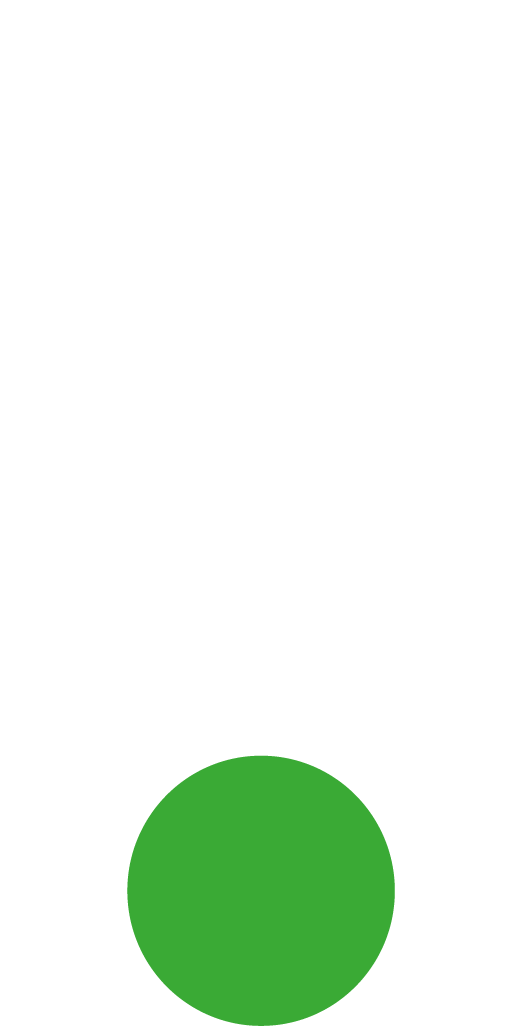
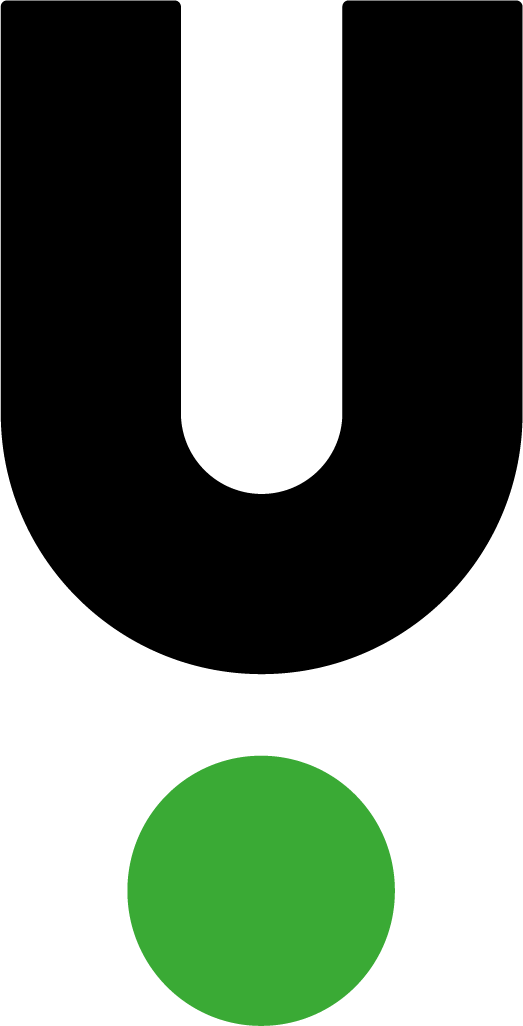
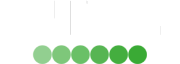

In [380]:

searching = requests.get("https://www.unibet.fr/sport/basketball/nba-basket-us?filter=Scoreurs&subFilter=Joueur%20marquant%2020%20points%20ou%20plus".format(str))
search_result = searching.text
print(search_result)

In [351]:
#Unibet Scrapping JSON

"""
Unibet odds scraper
"""

from collections import defaultdict
import datetime
import json

import requests

import sportsbetting as sb
from sportsbetting.database_functions import (
    is_player_in_db, add_player_to_db, is_player_added_in_db,
    add_new_player_to_db, is_in_db_site, get_formatted_name_by_id
)

def get_id_league(url):
    """
    Get league id from url
    """
    if "https://www.unibet.fr" not in url:
        return None, None
    public_url = url.split("https://www.unibet.fr")[1]
    request_url = "https://www.unibet.fr/zones/navigation.json?publicUrl="+public_url
    content = requests.get(request_url).content
    if "Nos services ne sont pas accessibles pour le moment et seront de retour au plus vite." in str(content):
        raise sb.UnavailableSiteException
    parsed = json.loads(content)
    sport = public_url.split("/")[2]
    if sport == "cotes-boostees":
        sport = public_url.split("-cotes-boostees")[0].split("/")[-1]
    if parsed["requestData"]:
        return parsed["requestData"].get("nodeId"), sport
    return None, None


def parse_unibet_api(id_league, sport, boost):
    """
    Get Unibet odds from league id and sport
    """
    parameter = ""
    if sport == "tennis":
        parameter = "Vainqueur%2520du%2520match"
    elif "basket" in sport:
        parameter = "Vainqueur%2520du%2520match%2520%2528prolong.%2520incluses%2529"
    else:
        parameter = "R%25C3%25A9sultat%2520du%2520match"
    url = ("https://www.unibet.fr/zones/sportnode/markets.json?nodeId={}&filter=R%25C3%25A9sultat&marketname={}"
           .format(id_league, parameter))
    content = requests.get(url).content
    parsed = json.loads(content)
    markets_by_type = parsed.get("marketsByType", [])
    odds_match = {}
    site_name = "unibet" + ("_boost" if boost else "")
    for market_by_type in markets_by_type:
        days = market_by_type["days"]
        for day in days:
            events = day["events"]
            for event in events:
                markets = event["markets"]
                for market in markets:
                    name = (market["eventHomeTeamName"].replace(" - ", "-")
                            + " - " + market["eventAwayTeamName"].replace(" - ", "-"))
                    date = datetime.datetime.fromtimestamp(market["eventStartDate"]/1000)
                    odds = []
                    selections = market["selections"]
                    for selection in selections:
                        price_up = int(selection["currentPriceUp"])
                        price_down = int(selection["currentPriceDown"])
                        odds.append(round(price_up / price_down + 1, 2))
                    odds_match[name] = {
                        "date":date,
                        "odds":{site_name:odds},
                        "id":{"unibet":event["eventId"]},
                        "competition":event["competitionName"]
                    }
    return odds_match

def parse_unibet(url, boost=False):
    """
    Get Unibet odds from url
    """
    id_league, sport = get_id_league(url)
    if id_league:
        return parse_unibet_api(id_league, sport, boost)
    print("Wrong unibet url")
    return {}


def get_sub_markets_players_basketball_unibet(id_match):
    """
    Get submarkets odds from basketball match
    """
    if not id_match:
        return {}
    url = 'https://www.unibet.fr/zones/event.json?eventId=' + id_match
    content = requests.get(url).content
    parsed = json.loads(content)
    markets_class_list = parsed.get('marketClassList', [])
    markets_to_keep = {
        'Performance du Joueur (Points + Rebonds + Passes)':'Points + passes + rebonds',
        'Nombre de passes du joueur':'Passes',
        'Nombre de rebonds du joueur':'Rebonds',
        'Performance du Joueur (Points + Passes)':'Points + passes',
        'Performance du Joueur (Points + Rebonds)':'Points + rebonds',
        'Performance du Joueur (Passes + Rebonds)':'Passes + rebonds',
        "Joueur marquant 20 points ou plus":"Points",
        "Joueur marquant 25 points ou plus":"Points",
        "Joueur marquant 30 points ou plus":"Points",
        "Joueur marquant 35 points ou plus":"Points",
        "Joueur marquant 40 points ou plus":"Points",
        "Equipe à domicile - Nombre de 3 points marqués":"3 Points",
        "Equipe à l'exterieur - Nombre de 3 points marqués":"3 Points",
        "Nombre total de 3 pts marqués dans le match":"3 Points"
    }
    sub_markets = {v:defaultdict(list) for v in markets_to_keep.values()}
    for market_class_list in markets_class_list:
        market_name = market_class_list['marketName']
        if market_name not in markets_to_keep:
            continue
        markets = market_class_list['marketList']
        for market in markets:
            team_name = market.get("event{}Name".format(market["marketType"]
                                                        .split(" - ")[0]
                                                        .replace(" ", "")))
            id_team = is_in_db_site(team_name, "basketball", "unibet")
            if id_team:
                ref_player = get_formatted_name_by_id(id_team[0])
            is_3_pts = "3 points marqués" in market["marketName"]
            if "3 pts marqués" in market["marketName"]:
                ref_player = "Match"
                is_3_pts = True
            selections = market['selections']
            for selection in selections:
                price_up = int(selection['currentPriceUp'])
                price_down = int(selection['currentPriceDown'])
                odd = round(price_up / price_down + 1, 2)
                limit = selection['name'].split(' de ')[(-1)].replace(",", ".")
                plus = "Plus de" in selection['name']
                if not is_3_pts:
                    player = selection['name'].split(' - ')[0]
                    ref_player = player
                    if is_player_added_in_db(player, "unibet"):
                        ref_player = is_player_added_in_db(player, "unibet")
                    elif is_player_in_db(player):
                        add_player_to_db(player, "unibet")
                    else:
                        if sb.DB_MANAGEMENT:
                            print(player, "unibet")
                            add_new_player_to_db(player)
                        else:
                            continue
                key_market = markets_to_keep[market_name]
                if key_market == "Points":
                    limit = str(float(market_name.split()[2])-0.5)
                key_player = ref_player + "_" + limit
                if key_player not in sub_markets[key_market]:
                    sub_markets[key_market][key_player] = {"odds":{"unibet":[]}}
                if plus:
                    sub_markets[key_market][key_player]["odds"]["unibet"].insert(0, odd)
                else:
                    sub_markets[key_market][key_player]["odds"]["unibet"].append(odd)
                if key_market == "Points":
                    sub_markets[key_market][key_player]["odds"]["unibet"].append(1.01)
    for sub_market in sub_markets:
        sub_markets[sub_market] = dict(sub_markets[sub_market])
    return sub_markets









ModuleNotFoundError: No module named 'sportsbetting'

In [82]:
df.columns
df.columns.droplevel(0)

lev0 = df.columns.get_level_values(0)
lev1 = df.columns.get_level_values(1)
new_col = lev0 + "_" + lev1
df.columns.droplevel(0).rename(new_col)

TypeError: Index.name must be a hashable type

In [47]:
df.rename(columns={('AST', 'mean'): ('AST', 'aaa')}).head()
df = pd.DataFrame([[1, 2, 3], [4, 5, 6], [7, 8, 9]],
                  columns=pd.MultiIndex.from_tuples([('a', 1), ('a', 2), ('b', 1)]))

lookup = {('a', 1): 'd', ('a', 2): 'e', ('b', 1): 'f'}

# flatten index
df.columns = df.columns.to_flat_index()

# rename using lookup
result = df.rename(columns=lookup)

print(result)

   d  e  f
0  1  2  3
1  4  5  6
2  7  8  9


In [220]:
df["ScoreJ"]=df["PTS_REB_AST"]["mean"]
df["NbGames"]=df["Minutes"]["count"]
#df = df.sort_values('ScoreJ', ascending=False)
df = df[df.columns.drop(list(df.filter(regex='count')))]
df = df[df.columns.drop(list(df.filter(regex='std')))]
df = df[df.columns.drop(list(df.filter(regex='50%')))]
df = df[df.columns.drop(list(df.filter(regex='mean')))]
df = df[['NbGames', 'PTS_REB_AST', 'PTS_REB', 'PTS_AST', 'REB_AST', 'PTS', 'REB', 'AST', 'TPTW', 'Minutes', 'ScoreJ', '20PTS', '25PTS', '30PTS', 'URL']]

#df1 = player_team.drop_duplicates().reset_index(drop=True)
#df = df.reset_index()
#a = df[['Player']].merge(df1, on='Player', how='left')
#df["Team"] = a[["team_i"]]
df = df.sort_values(['Team', 'ScoreJ'], ascending=[True, False])
#df = df.drop(df.columns[3], axis=1)

KeyError: "['URL'] not in index"

In [217]:
#TO CHANGE
# min à 0 lorsque joue pas
# Prendre en compte blessure top7 joueurs
# Ratio sur les derniers matchs
# https://www.espn.com/nba/injuries
# https://www.espn.com/nba/player/gamelog/_/id/3136195/karl-anthony-towns not recognise

cm = sns.light_palette("green", as_cmap=True)
bl = sns.light_palette("blue", as_cmap=True)
rd = sns.light_palette("red", as_cmap=True)
pr = sns.light_palette("purple", as_cmap=True)
rg = sns.light_palette("orange", as_cmap=True)
#df[df['PTS']['max']>=20].style.background_gradient(cmap=rd, subset=['ScoreJ', 'TPTW']).background_gradient(cmap=bl, subset=['PTS_REB_AST', 'PTS_REB', 'PTS_AST']).background_gradient(cmap=cm, subset=['PTS', 'REB', 'AST']).background_gradient(cmap=pr, subset=['Minutes']).background_gradient(cmap=rg, subset=['Minutes']).set_precision(0)
df[df['ScoreJ']>=6].style.background_gradient(cmap=rd, subset=['ScoreJ', 'TPTW']).background_gradient(cmap=bl, subset=['PTS_REB_AST', 'PTS_REB', 'PTS_AST']).background_gradient(cmap=cm, subset=['PTS', 'REB', 'AST']).background_gradient(cmap=pr, subset=['Minutes']).background_gradient(cmap=rg, subset=['Minutes']).set_precision(0)

In [178]:
#TO CHANGE
# min à 0 lorsque joue pas
# Prendre en compte blessure top7 joueurs
# Ratio sur les derniers matchs
# https://www.espn.com/nba/injuries
# https://www.espn.com/nba/player/gamelog/_/id/3136195/karl-anthony-towns not recognise

cm = sns.light_palette("green", as_cmap=True)
bl = sns.light_palette("blue", as_cmap=True)
rd = sns.light_palette("red", as_cmap=True)
pr = sns.light_palette("purple", as_cmap=True)
rg = sns.light_palette("orange", as_cmap=True)
df[df['ScoreJ']>=6].style.background_gradient(cmap=rd, subset=['ScoreJ', 'TPTW']).background_gradient(cmap=bl, subset=['PTS_REB_AST', 'PTS_REB', 'PTS_AST']).background_gradient(cmap=cm, subset=['PTS', 'REB', 'AST']).background_gradient(cmap=pr, subset=['Minutes']).background_gradient(cmap=rg, subset=['Minutes']).set_precision(0)

In [128]:
# Webscrapping Unibet

Pages = ["https://www.unibet.fr/sport/basketball/nba-basket-us?filter=Scoreurs&subFilter=Joueur%20marquant%2020%20points%20ou%20plus",
         "https://www.unibet.fr/sport/basketball/nba-basket-us?filter=Scoreurs&subFilter=Joueur%20marquant%2025%20points%20ou%20plus",
         "https://www.unibet.fr/sport/basketball/nba-basket-us?filter=Scoreurs&subFilter=Joueur%20marquant%2030%20points%20ou%20plus",
         "https://www.unibet.fr/sport/basketball/nba-basket-us?filter=Scoreurs&subFilter=Joueur%20marquant%2035%20points%20ou%20plus",
         "https://www.unibet.fr/sport/basketball/nba-basket-us?filter=Scoreurs&subFilter=Joueur%20marquant%2040%20points%20ou%20plus"]
for p in Pages:
    get_page(p)
    ###### Get list of Games
    soup = BeautifulSoup(driver.page_source)

    for game in soup.find(class_="ui-mainview-block eventpath-wrapper").findAll(class_ = re.compile("ui-touchlink had-market block-market calendar-event cell event_.*")):
        print("")
        for player in game.findAll(class_="oddc"):
            odd = float(str(player.find(class_="ui-touchlink-needsclick price odd-price")).split('odd-price">')[1].split('</span>')[0].replace(" ", ""))
            player = player.find(class_="ui-touchlink-needsclick ui-oddbutton")['title']
            print(player + " = " + str(odd))


Julius Randle = 1.42
Kemba Walker = 3.1
RJ Barrett = 3.6

Christian Wood = 2.05
Kevin Porter Jr. = 3.1
Jalen Green = 4.6
Donovan Mitchell = 1.3
Mike Conley = 3.6
Rudy Gobert = 4.1

Luka Doncic = 1.08
Tim Hardaway Jr. = 2.05
Dorian Finney-Smith = 2.55
Dejounte Murray = 2.25
Derrick White = 2.55
Keldon Johnson = 3.1

Julius Randle = 2.0
Kemba Walker = 5.1
RJ Barrett = 5.6

Christian Wood = 3.5
Kevin Porter Jr. = 5.0
Daniel Theis = 7.75
Donovan Mitchell = 1.7
Mike Conley = 6.0
Rudy Gobert = 6.5

Luka Doncic = 1.25
Tim Hardaway Jr. = 3.5
Dorian Finney-Smith = 10.0
Dejounte Murray = 4.2
Derrick White = 4.65
Keldon Johnson = 5.1

Julius Randle = 3.6
Evan Fournier = 7.0
Kemba Walker = 8.5

Christian Wood = 5.75
Kevin Porter Jr. = 8.5
Donovan Mitchell = 2.85
Mike Conley = 10.5
Rudy Gobert = 11.5

Luka Doncic = 1.72
Tim Hardaway Jr. = 5.75
Dorian Finney-Smith = 20.0
Dejounte Murray = 6.5
Derrick White = 7.5
Keldon Johnson = 20.0

Julius Randle = 5.5
Evan Fournier = 8.0

Christian Wood = 10.0
D

In [170]:
soup = BeautifulSoup(driver.page_source)
button = soup.findAll(class_="oddsbox custom_market-participant participant-market outrights-column-1")[0]
print(type(button))

button = soup.findAll(class_="collapse-more_wrapper")[0]
print(type(button))

button = soup.findAll(class_="fa fa-fw fa-plus-circle")[0]
print(type(button))

from selenium.webdriver.common.action_chains import ActionChains

#ActionChains(driver).move_to_element(button)#.click(button_sub).perform()

#element = soup.find_element_by_id("view-more-toggle ui-collapse-more")

button

<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>


<em class="fa fa-fw fa-plus-circle"></em>

In [130]:
# Webscrapping Unibet

Pages = ["https://www.unibet.fr/sport/basketball/nba-basket-us?filter=Sp%C3%A9cial%20joueurs&subFilter=Performance%20du%20Joueur%20%28Points%20%2B%20Rebonds%20%2B%20Passes%29",
         "https://www.unibet.fr/sport/basketball/nba-basket-us?filter=Sp%C3%A9cial%20joueurs&subFilter=Performance%20du%20Joueur%20%28Points%20%2B%20Rebonds%29",
         "https://www.unibet.fr/sport/basketball/nba-basket-us?filter=Sp%C3%A9cial%20joueurs&subFilter=Performance%20du%20Joueur%20%28Points%20%2B%20Passes%29",
         "https://www.unibet.fr/sport/basketball/nba-basket-us?filter=Sp%C3%A9cial%20joueurs&subFilter=Performance%20du%20Joueur%20%28Passes%20%2B%20Rebonds%29",
         "https://www.unibet.fr/sport/basketball/nba-basket-us?filter=Sp%C3%A9cial%20joueurs&subFilter=Nombre%20de%20rebonds%20du%20joueur",
         "https://www.unibet.fr/sport/basketball/nba-basket-us?filter=Sp%C3%A9cial%20joueurs&subFilter=Nombre%20de%20passes%20du%20joueur"]

for p in Pages:
    get_page(p)
    ###### Get list of Games
    soup = BeautifulSoup(driver.page_source)
    
    for game in soup.findAll(class_="oddsbox custom_market-participant participant-market outrights-column-1"):
        print("")
        for player in game.findAll(class_="ui-touchlink-needsclick ui-oddbutton"):
            odd = float(str(player.find(class_="ui-touchlink-needsclick price odd-price")).split('odd-price">')[1].split('</span>')[0].replace(" ", ""))
            player = player['title']
            print(player + " = " + str(odd))



Evan Fournier - Moins de 20.5 = 1.74
Evan Fournier - Plus de 20.5 = 1.84
Julius Randle - Moins de 38.5 = 1.78

Christian Wood - Moins de 31.5 = 1.74
Christian Wood - Plus de 31.5 = 1.86
Daniel Theis - Moins de 14.5 = 1.78
Donovan Mitchell - Moins de 34.5 = 1.76
Donovan Mitchell - Plus de 34.5 = 1.84
Mike Conley - Moins de 23.5 = 1.78

Dorian Finney-Smith - Moins de 18.5 = 1.84
Dorian Finney-Smith - Plus de 18.5 = 1.76
Luka Doncic - Moins de 48.5 = 1.84
Dejounte Murray - Moins de 32.5 = 1.8
Dejounte Murray - Plus de 32.5 = 1.8
Derrick White - Moins de 25.5 = 1.74

Evan Fournier - Moins de 17.5 = 1.8
Evan Fournier - Plus de 17.5 = 1.8
Julius Randle - Moins de 32.5 = 1.86

Christian Wood - Moins de 29.5 = 1.74
Christian Wood - Plus de 29.5 = 1.84
Daniel Theis - Moins de 13.5 = 1.76
Donovan Mitchell - Moins de 29.5 = 1.82
Donovan Mitchell - Plus de 29.5 = 1.78
Mike Conley - Moins de 17.5 = 1.82

Dorian Finney-Smith - Moins de 16.5 = 1.84
Dorian Finney-Smith - Plus de 16.5 = 1.76
Luka Donc

In [ ]:
d = pd.DataFrame()

###### Get_Page function
def get_page(special_match):
    driver.get(special_match)
    try:
        element = driver.find_element_by_class_name('banner-actions-container')
        element.click()
    except:
        do = "nothing"
            
for jj in range(len(list_Pages)):
    Page = list_Pages[jj]
    Players = list_Players[jj]
    print(Page.replace("https://www.espn.com/nba/team/schedule/_/name/", "").replace("/seasontype/2", ""))

    ###### Game/Games
    #get_page(special_match)
    get_page(Page)

    ###### Get list of Games
    soup = BeautifulSoup(driver.page_source)
    list_games = []

    for hrefs in soup.find(class_='Table__TBODY').findAll(class_='AnchorLink', href=re.compile("gameId")):
        list_games.append(hrefs['href'].replace("/game/", "/boxscore/"))

    index_games = soup.prettify().split("DATE\n")[1].split("data-idx")
    index_games = int(index_games[len(index_games)-1].split('">\n ')[0].split('="')[1])
    list_games = list_games[0:index_games-1]

    get_page(Players)
    soup = BeautifulSoup(driver.page_source)

    list_href_players = []
    for href_players in soup.find(class_='Table__TBODY').findAll(class_='AnchorLink', href=re.compile("player/_/id/")):
        list_href_players.append(href_players['href'].replace("https://www.espn.com/nba/player/_/id/", ""))

    def filterOut2(x):return x.split('-')[1]
    list_href_players = list(map(filterOut2, list_href_players))
    list_href_players

    for games in list_games:
        get_page(games)
        soup = BeautifulSoup(driver.page_source)

        ############ Creation of the dataset
        for i in range(0, 2): #0 to 1 because two teams
            my_table = soup.findAll(class_='content desktop')[i]
            Team_finded = my_table.find(class_='team-name')

            #Team_finded = my_table.contents[1]
            if 1 == 1:

                my_table = my_table.find(class_='mod-data')

                table_data = []
                for row in my_table.findAll('tr'):
                    row_data = []    
                    for cell in row.findAll('td'):
                        row_data.append(cell.text)
                    if(len(row_data) > 0):
                        if(any(string in row_data[0].lower() for string in list_href_players)):
                            if(row_data[0] == "TEAM" or row_data[0] == "" or len(row_data[0])==1):
                                do = "nothing"
                            else:
                                if('DNP' in row_data[1] or 
                                   row_data[0] == "TEAM"):
                                    data_item = {"Player": row_data[0],
                                                  "Minutes": 0}
                                else:
                                    if(jj<10):
                                        num = "0" + str(jj)
                                    else:
                                        num = str(jj)
                                    
                                    if float(row_data[14])>=20: PT20 = 1
                                    else: PT20 = 0
                                    if float(row_data[14])>=25: PT25 = 1
                                    else: PT25 = 0
                                    if float(row_data[14])>=30: PT30 = 1
                                    else: PT30 = 0
                                            
                                    data_item = {"Player": row_data[0],#.Substring(0, input.FirstIndexOf(".")),
                                                  "Minutes": row_data[1],
                                                  "FG": row_data[2],
                                                  "3PT": row_data[3],
                                                  "FT": row_data[4],
                                                  "OREB": row_data[5],
                                                  "DREB": row_data[6],
                                                  "REB": row_data[7],
                                                  "AST": row_data[8],
                                                 #calculated columns
                                                  "PTS_REB_AST": float(row_data[14])+float(row_data[7])+float(row_data[8]),
                                                  "PTS_REB": float(row_data[14])+float(row_data[7]),
                                                  "PTS_AST": float(row_data[14])+float(row_data[8]),
                                                  "20PTS": PT20,
                                                  "25PTS": PT25,
                                                  "30PTS": PT30,
                                                  "STL": row_data[9],
                                                  "BLK": row_data[10],
                                                  "TO": row_data[11],
                                                  "PF": row_data[12],
                                                  "PlusMinus": row_data[13],
                                                  "PTS": row_data[14],
                                                  "Team": num + "_" + Page.replace("https://www.espn.com/nba/team/schedule/_/name/", "").replace("/seasontype/2", ""),
                                                  "team":any(string in row_data[0].lower() for string in list_href_players)
                                    }
                            table_data.append(data_item)

                data = pd.DataFrame(table_data)[:-1]
                #team_name = pd.DataFrame(columns=data.columns)
                #team_name.loc[len(team_name)] = "0"
                #team_name.rename(index={len(team_name)-1: Page.replace("https://www.espn.com/nba/team/schedule/_/name/", "").replace("/seasontype/2", "")})
                #print(team_name)
                #d = pd.concat([d,team_name])
                d = pd.concat([d,data])
                #d.append(data)#d = [d, data]
                
                
d.dropna(subset = ["REB"], inplace=True)
d["3PT"] = d["3PT"].astype(str)
d = d.assign(TPTW = d['3PT'].map(lambda x: x.split('-')[0]))
d["TPTW"] = d["TPTW"].astype(int, errors = 'raise')
d["REB"] = d["REB"].astype(int, errors = 'raise')
d["AST"] = d["AST"].astype(int, errors = 'raise')
d["PTS"] = d["PTS"].astype(int, errors = 'raise')
d["PTS_REB_AST"] = d["PTS_REB_AST"].astype(int, errors = 'raise')
d["PTS_REB"] = d["PTS_REB"].astype(int, errors = 'raise')
d["PTS_AST"] = d["PTS_AST"].astype(int, errors = 'raise')
d["Minutes"] = d["Minutes"].astype(int, errors = 'raise')

player_team = d[['Player','Team']]
df = d.groupby(['Player', 'Team']).describe(percentiles=[.5])
df = df[df['REB']['count']>=2]
a = df["Minutes"].sort_values(by = "mean", ascending = False, axis=0).index
df = df.reindex(a)



In [6]:
if MODE == "day":
    if Day == "Today":
        day = datetime.today()
    else:
        day = datetime.today() + timedelta(days = 1) 
    driver.get('https://www.oddsportal.com/matches/' + sport + '/'+ day.strftime("%Y%m%d") + '/')
    pages="1"
else:
    if MODE == "match":
        driver.get(special_match)
        pages="1"
    else:
        if MODE == "tournaments":
            pages=tournaments

d = pd.DataFrame()
for page in pages:
    if MODE == "tournaments":
        driver.get(page)
        
    soup = BeautifulSoup(driver.page_source)
    p = soup.find_all('strong')

    ############ Creation of the dataset
    T = soup.find('table', class_='table-main')
    my_table = T
    T.find('tr',class_='dark center').decompose()

    table_data = []
    for row in my_table.findAll('tr'):
        row_data = []    

        for cell in row.findAll('td'):
            row_data.append(cell.text)
        if(len(row_data) > 0):
            data_item = {"DateTime": row_data[0],
                          "Players": row_data[1],
                          "Odd1": row_data[2],
                          "OddX": row_data[3],
                          "Odd2": row_data[4],
                          "Add": row_data[5]
            }
            table_data.append(data_item)
    data = pd.DataFrame(table_data)
#     print(str(re.search('.*/(.*)/', page)))
#     data["tournament"] = re.search('.*/(.*)/', str(page)).group(1)
    d = pd.concat([d, data.head(nblines)])
    ############ Dataset
df = d.reindex()
df = df[df['Players'].str.count('/')<2] #Remove duo
df = df[df['Odd1'].str.contains("[1-9]")]
df = df[df['Odd2'].str.contains("[1-9]")]
# df = df[df['Players'].str.count('-')==1] # Remove names with '-'
df = df[np.invert(df['Odd1'].str.contains(":"))] # Remove match already started
df = df.assign(Player1 = df['Players'].map(lambda x: x.split(' - ')[0]),
               Player2 = df['Players'].map(lambda x: x.split(' - ')[1])).drop("Add", axis = 1).head(nblines)
Players1 = df['Player1'].tolist()
Players2 = df['Player2'].tolist()
Players1 = [w.replace('\xa0', '') for w in Players1]
Players2 = [w.replace('\xa0', '') for w in Players2]
Players = [None]*(len(Players1)+len(Players2))
Players[::2] = Players1
Players[1::2] = Players2
Odd1 = df['Odd1'].tolist()
Odd2 = df['Odd2'].tolist()
Odd1 = [w.replace('\xa0', '') for w in Odd1]
Odd2 = [w.replace('\xa0', '') for w in Odd2]
Odds = [None]*(len(Odd1)+len(Odd2))
Odds[::2] = Odd1
Odds[1::2] = Odd2
params = [Players,Odds]
Players = [w.strip().replace(' ', '+') for w in Players]
#Players
#     data_res = pd.concat([data_res, df.head(nblines).reindex()])

data_res = df#.reindex()
def Challenger (row):
    if (row['Odd1'] < row['Odd2']) :
        return row['Player1'].strip()
    else :
        if (row['Odd2'] < row['Odd1']) :
            return row['Player2'].strip()
        else:
            return "-"
data_res["Challenger"] = data_res.apply(lambda row: Challenger(row), axis=1)
data_res.head()

AttributeError: 'NoneType' object has no attribute 'decompose'

In [106]:
data_res

,DateTime,Players,Odd1,OddX,Odd2,Player1,Player2,Challenger,NbrowC,Chall1.5,Chall2.0,Chall2.5,NbrowN,NoChall1.5,NoChall2.0,NoChall2.5
1,16:00,Ferencvaros (Hun) - Prishtina (Kos),1.12,8.35,20.46,Ferencvaros (Hun),Prishtina (Kos),Ferencvaros (Hun),39.0,NaN,NaN,NaN,36.0,0.813333,0.000000,2.040000
2,16:00,Flora (Est) - Hibernians (Mlt),1.57,3.92,5.46,Flora (Est),Hibernians (Mlt),Flora (Est),37.0,1.111304,1.032000,1.495000,39.0,0.715000,0.775000,1.418000
3,16:00,HJK (Fin) - Buducnost (Mne),1.51,4.21,6.00,HJK (Fin),Buducnost (Mne),HJK (Fin),39.0,1.087500,0.950000,1.520000,2.0,0.000000,0.000000,NaN
4,17:00,CFR Cluj (Rou) - Borac Banja Luka (Bih),1.29,4.93,12.17,CFR Cluj (Rou),Borac Banja Luka (Bih),CFR Cluj (Rou),39.0,0.940000,1.105000,1.802500,36.0,NaN,0.533333,0.793333
5,17:00,Zalgiris (Ltu) - Linfield (Nir),1.62,3.72,5.45,Zalgiris (Ltu),Linfield (Nir),Zalgiris (Ltu),37.0,NaN,NaN,NaN,40.0,NaN,NaN,1.590000
6,17:30,Fola (Lux) - Lincoln Red Imps (Gib),1.40,4.11,8.90,Fola (Lux),Lincoln Red Imps (Gib),Fola (Lux),36.0,0.977500,0.516667,2.140000,35.0,1.180000,1.850000,0.000000
7,18:00,Shkendija (Mkd) - Mura (Slo),2.59,3.21,2.74,Shkendija (Mkd),Mura (Slo),Shkendija (Mkd),39.0,0.822222,1.225455,1.376667,40.0,1.070000,1.262500,0.882000
9,16:00,Bodo/Glimt (Nor) - Legia (Pol),2.43,3.21,2.87,Bodo/Glimt (Nor),Legia (Pol),Bodo/Glimt (Nor),40.0,1.180000,1.179231,1.403333,40.0,0.763333,0.760909,0.918824
10,16:00,Dinamo Tbilisi (Geo) - Neftci Baku (Aze),2.06,3.39,3.40,Dinamo Tbilisi (Geo),Neftci Baku (Aze),Dinamo Tbilisi (Geo),39.0,0.837857,1.375455,1.278571,39.0,1.335000,0.676000,0.000000
11,16:30,Slovan Bratislava (Svk) - Shamrock Rovers (I...,1.67,3.68,4.99,Slovan Bratislava (Svk),Shamrock Rovers (Irl),Slovan Bratislava (Svk),39.0,NaN,NaN,NaN,2.0,1.105000,NaN,NaN


In [109]:
i=1

############Loop on Players
for Player in Players:
    Player = Player[:Player.find('(')].strip().strip()
    Player = Player.strip().replace(" ", "+")
    print(Player)
    p = Player.strip() + '/' + sport + '/'
    driver.get('https://www.oddsportal.com/search/results/' + p)
    soup = BeautifulSoup(driver.page_source)
    p2 = soup.find_all('strong')
    
    table_data = []
    for npages in range(0,nbpages):
        ############ Getting URL
        paragraphs = []
        for x in p2:
            paragraphs.append(str(x))
        if any("(" in s for s in paragraphs): #if <span>Results (0)</span>
            result = [s for s in paragraphs if "(" in s]
            result = [re.sub(".*\(", "", x) for x in result]
            result = [re.sub("\).*", "", x) for x in result]
            if result == ['0']:
                if npages == 0:
#                     print(Player.strip().replace("+", " "))
#                     print(soup.find('tbody').find_all('tr').find_previous("a", {"class": "href"}))
#                     print([a.get_text() for a in soup.select('tr a')])
#                     print(str(soup)[:str(soup).find(Player +'</span></a>')].replace("results/","").replace('/">',""))
                    PlayerCode = str(soup)[str(soup).find('<span class="bold">' + Player.strip().replace("+", " ") +'</span>')-20:str(soup).find('<span class="bold">' + Player.strip().replace("+", " ") +'</span>')].replace("results/","").replace('/">',"")
#                     PlayerCode = soup.find('tr', class_='odd').find('a').get('href').replace("/search/results/","").replace("/","")
                #page = getPage(soup.find('tr', class_='odd').find('a').get('href').split("[/:]").replace("/", "") + '/')
                driver.get('https://www.oddsportal.com/search/results/' + PlayerCode + "/page/"+ str(npages+1) + "/")
                soup = BeautifulSoup(driver.page_source)
#                 print(str(soup).find("Results (0)")!=-1)
                if((str(soup).find("Results (0)")!=-1) | (str(soup).find("Page not found")!=-1)):
                    driver.get('https://www.oddsportal.com/search/results/' + p)
                    soup = BeautifulSoup(driver.page_source)
#                     print(str(soup))
#                     print( str(soup)[str(soup).find(Player.replace("+", " ").strip() +'</a>')-30:str(soup).find(Player.replace("+", " ").strip() +'</a>')])
                    print(Player.replace("+", " ").strip())
                    PlayerCode = str(soup)[str(soup).find('>' + Player.replace("+", " ").strip() +'</a>')-20:str(soup).find('>' +Player.replace("+", " ").strip() +'</a>')].replace("results/","").replace('/">',"").replace('/',"").replace('"',"")
                    print(PlayerCode)
                    driver.get('https://www.oddsportal.com/search/results/' + PlayerCode + "/page/"+ str(npages+1) + "/")
                    soup = BeautifulSoup(driver.page_source)
        ############ Creation of the dataset
        T = soup.find('table', class_='table-main')
        if (T.find('tr',class_='dark center')!=None):
            my_table = T
            T.find('tr',class_='dark center').decompose()

            for row in my_table.findAll('tr'):
                row_data = []    

                for cell in row.findAll('td'):
                    row_data.append(cell.text)
                if(len(row_data) > 0):
                    data_item = {"DateTime": row_data[0],
                                 "Players": row_data[1],
                                 "Result": row_data[2],
                                 "Odd1": row_data[3],
                                 "OddX": row_data[4],
                                 "Odd2": row_data[5],
                                 "Bs": row_data[6]
                    }
                    table_data.append(data_item)

    data = pd.DataFrame(table_data)
    #data["Date"] = data["DateTime"].astype(str).str[0:5]
    #data = data[data["Date"] > (day + timedelta(days = -history)).strftime("%d/%m")]
    #if (len(data.index) != 0):
    ############ Dataset
    def cancel(row):
        if row['Result'].find(":")!= -1 :
             return 0
        else :
             return 1
    df = data
    df["cancel"] = df.apply(lambda row: cancel(row), axis=1)
    df = df[df["cancel"] == 0]
    
    df = df.assign(Player1 = df['Players'].map(lambda x: x.split('-')[0]),
                   Player2 = df['Players'].map(lambda x: x.split('-')[1]),
                   Score1 = df['Result'].map(lambda x: x.split(':')[0]),
                   Score2 = df['Result'].map(lambda x: x.split(':')[1])
                  ).drop("Players", axis = 1)
    df = df[df['Odd1'].str.contains("[1-9]")]
    df = df[df['OddX'].str.contains("[1-9]")]
    df = df[df['Odd2'].str.contains("[1-9]")]
    df = df[~df['Result'].str.contains(("[A-Za-z]+"))]
    ############ Data column type
    df['Score1'] = df['Score1'].astype(int, errors = 'raise')
    df['Score2'] = df['Score2'].astype(int, errors = 'raise')
    df['Odd1'] = df['Odd1'].astype(float, errors = 'raise')
    df['Odd2'] = df['Odd2'].astype(float, errors = 'raise')
    df['Player1'] = df['Player1'].astype(str)
    df['Player2'] = df['Player2'].astype(str)
    #PlayerName = df[df["Player2"].str.contains(PlayerName)]["Player2"].values[0]
    ############ Functions
    def Winner (row):
        if (row['Score1'] > row['Score2']) :
            return row['Player1'].strip()
        else :
            if (row['Score2'] > row['Score1']) :
                return row['Player2'].strip()
            else:
                return "-"
    def OddWinner (row):
        if (row['Score1'] > row['Score2']) :
            return row['Odd1']
        else :
            return row['Odd2']
    def round_of_rating(number):
        if number < 3 :
            if number > 0.5 :
                return number
            else:
                return 0.5
        else :
            return 3
    def Challenger (row):
        if (row['Odd1'] < row['Odd2']) :
            return row['Player1'].strip()
        else :
            if (row['Odd2'] < row['Odd1']) :
                return row['Player2'].strip()
            else:
                return "-"
    def NbSetChallenger (row):
        if (row['Challenger'] == row['Player1']) :
            return  row['Score1']/(row['Score1']+row['Score2']) #2/3 or 1
        else :
            return  row['Score2']/(row['Score1']+row['Score2']) #2/3 or 1
#     def Analysis (row):
#         if (row['TargetPlayer'] in row['Winner'].strip()) :
#             if (row['Challenger'].strip() == row['TargetPlayer']) :
#                 return  11 + 1/round_of_rating(row['OddDiff']) - 3*(1-row['NbSetChallenger'])
#             else:
#                 return  13 + round_of_rating(row['OddDiff']) - 3*(1-row['NbSetChallenger'])
#         else :
#             if (row['Challenger'].strip() == row['TargetPlayer']) :
#                 return  10-3 - round_of_rating(row['OddDiff']) + 3*(1-row['NbSetChallenger'])
#             else:
#                 return  10-1 - 1/round_of_rating(row['OddDiff']) + 3*(1-row['NbSetChallenger'])
    def toBet(row, lastMatchs):
        if (row["Analysis1_" + str(lastMatchs)] > row["Analysis2_" + str(lastMatchs)]):
            if (row["Odd1"] > row["Odd2"]):
                return row["Analysis1_" + str(lastMatchs)] - row["Analysis2_" + str(lastMatchs)]
            else:
                return -(row["Analysis1_" + str(lastMatchs)] - row["Analysis2_" + str(lastMatchs)])
        else:
            if (row["Odd2"] > row["Odd1"]):
                return row["Analysis2_" + str(lastMatchs)] - row["Analysis1_" + str(lastMatchs)]
            else:
                return -(row["Analysis2_" + str(lastMatchs)] - row["Analysis1_" + str(lastMatchs)])
    ############ Aplply Functions   
    df["TargetPlayer"] = Player.replace("+", " ").strip()
    df["Winner"] = df.apply(lambda row: Winner(row), axis=1)
    df["OddWinner"] = df.apply(lambda row: OddWinner(row), axis=1)
    df["Challenger"] = df.apply(lambda row: Challenger(row), axis=1)
    if(any(data_res['Challenger'].str.contains(Player.replace("+", " ").strip(), na=False))):
        data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), "NbrowC"] = len(df)
        df["Chall1.5"] = df.apply(lambda row: 1 if ((row["TargetPlayer"]==row["Challenger"])  & ((round(row["Odd1"]*100) in range(100, 150)) | (round(row["Odd2"]*100) in range(100, 150)))) else 0, axis=1)
        df["Chall2.0"] = df.apply(lambda row: 1 if ((row["TargetPlayer"]==row["Challenger"])  & ((round(row["Odd1"]*100) in range(150, 200)) | (round(row["Odd2"]*100) in range(150, 200)))) else 0, axis=1)
        df["Chall2.5"] = df.apply(lambda row: 1 if ((row["TargetPlayer"]==row["Challenger"])  & ((round(row["Odd1"]*100) in range(200, 250)) | (round(row["Odd2"]*100) in range(200, 250)))) else 0, axis=1)
        if (i % 2 == 0):
            data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'Chall1.5'] = df[(df["Chall1.5"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["Chall1.5"]==1)])
            data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'Chall2.0'] = df[(df["Chall2.0"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["Chall2.0"]==1)])
            data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'Chall2.5'] = df[(df["Chall2.5"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["Chall2.5"]==1)])
        else:
            data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'Chall1.5'] = df[(df["Chall1.5"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["Chall1.5"]==1)])
            data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'Chall2.0'] = df[(df["Chall2.0"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["Chall2.0"]==1)])
            data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'Chall2.5'] = df[(df["Chall2.5"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["Chall2.5"]==1)])
    else:
        data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), "NbrowN"] = len(df)
        df["NoChall1.5"] = df.apply(lambda row: 1 if ((row["TargetPlayer"]!=row["Challenger"])  & ((round(row["Odd1"]*100) in range(100, 150)) | (round(row["Odd2"]*100) in range(100, 150)))) else 0, axis=1)
        df["NoChall2.0"] = df.apply(lambda row: 1 if ((row["TargetPlayer"]!=row["Challenger"])  & ((round(row["Odd1"]*100) in range(150, 200)) | (round(row["Odd2"]*100) in range(150, 200)))) else 0, axis=1)
        df["NoChall2.5"] = df.apply(lambda row: 1 if ((row["TargetPlayer"]!=row["Challenger"])  & ((round(row["Odd1"]*100) in range(200, 250)) | (round(row["Odd2"]*100) in range(200, 250)))) else 0, axis=1)
        if (i % 2 == 0):
            data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'NoChall1.5'] = df[(df["NoChall1.5"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["NoChall1.5"]==1)])
            data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'NoChall2.0'] = df[(df["NoChall2.0"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["NoChall2.0"]==1)])
            data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'NoChall2.5'] = df[(df["NoChall2.5"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["NoChall2.5"]==1)])
        else:
            data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'NoChall1.5'] = df[(df["NoChall1.5"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["NoChall1.5"]==1)])
            data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'NoChall2.0'] = df[(df["NoChall2.0"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["NoChall2.0"]==1)])
            data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'NoChall2.5'] = df[(df["NoChall2.5"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["NoChall2.5"]==1)])

#     df[(df["Chall1.5"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["Chall1.5"]==1)])
#         df["NbSetChallenger"] = df.apply(lambda row: NbSetChallenger(row), axis=1)
#         dfall = df

#     for nmatch in nblastmatch:
#         df = dfall.head(nmatch)
#         if (i % 2 == 0):
#             data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'Analysis2_' + str(nmatch)] = round(df.apply(lambda row: Analysis(row), axis=1).mean(),2)
#             data_res["toBet_" + str(nmatch)] = data_res.apply(lambda row: toBet(row, nmatch), axis=1)   
#         else:
#             data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'Analysis1_' + str(nmatch)] = round(df.apply(lambda row: Analysis(row), axis=1).mean(),2)
  
        ##Nb Win when favorite, Nb Loss when Favorite .....

    i=i+1

data_res.head(5)

Hak
KuP


<ipython-input-109-d3bd63d70e01>:166: RuntimeWarning: invalid value encountered in double_scalars
  data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'Chall1.5'] = df[(df["Chall1.5"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["Chall1.5"]==1)])
<ipython-input-109-d3bd63d70e01>:167: RuntimeWarning: invalid value encountered in double_scalars
  data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'Chall2.0'] = df[(df["Chall2.0"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["Chall2.0"]==1)])
<ipython-input-109-d3bd63d70e01>:168: RuntimeWarning: invalid value encountered in double_scalars
  data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'Chall2.5'] = df[(df["Chall2.5"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["Chall2.5"]==1)])


Honk


<ipython-input-109-d3bd63d70e01>:170: RuntimeWarning: invalid value encountered in double_scalars
  data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'Chall1.5'] = df[(df["Chall1.5"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["Chall1.5"]==1)])
<ipython-input-109-d3bd63d70e01>:171: RuntimeWarning: invalid value encountered in double_scalars
  data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'Chall2.0'] = df[(df["Chall2.0"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["Chall2.0"]==1)])
<ipython-input-109-d3bd63d70e01>:172: RuntimeWarning: invalid value encountered in double_scalars
  data_res.loc[data_res['Players'].str.contains(Player.replace("+", " ").strip(), na=False), 'Chall2.5'] = df[(df["Chall2.5"]==1) & (df["Challenger"]==df["Winner"])]["OddWinner"].sum() / len(df[(df["Chall2.5"]==1)])


AC+Oul
HIF
HIF
script><body><html
HIF
script><body><html


ValueError: Wrong number of items passed 0, placement implies 1

In [97]:
pp = "Flora+"


pp.replace("+", " ").strip()

'Flora'

In [68]:
data_res['Odd1'] = data_res['Odd1'].astype(float, errors = 'raise')
data_res['Odd2'] = data_res['Odd2'].astype(float, errors = 'raise')

def Analysis (row):
    if ((round(row["Odd1"]*100) in range(100, 150)) | (round(row["Odd2"]*100) in range(100, 150))):
        return row['Chall1.5'] - row['NoChall1.5']
    else:
        if ((round(row["Odd1"]*100) in range(150, 200)) | (round(row["Odd2"]*100) in range(150, 200))):
            return row['Chall2.0'] - row['NoChall2.0']
        else:
            if ((round(row["Odd1"]*100) in range(200, 250)) | (round(row["Odd2"]*100) in range(200, 250))):
                return row['Chall2.5'] - row['NoChall2.5']
            else:
                return 0;

data_res["Analysis"] = data_res.apply(lambda row: Analysis(row), axis=1)
data_res = data_res.sort_values(by = "Analysis", ascending = False, axis=0)
data_res

KeyError: 'Chall2.5'

In [67]:
# data_res.drop(["DateTime","Players","Chall1.5","Chall2.0","Chall2.5","NoChall1.5","NoChall2.0","NoChall2.5","NbrowC","NbrowN"], axis=1, inplace=True)
data_res.reset_index(drop=True).style.background_gradient(cmap="Blues_r").set_precision(2)

,Odd1,OddX,Odd2,Player1,Player2,Challenger,Analysis
0,2.43,3.30,2.94,Sandefjord,Sarpsborg 08,Sandefjord,1.03
1,2.04,3.30,3.80,AC Oulu,KTP,AC Oulu,0.81
2,1.58,4.13,5.45,Valerenga,Lillestrom,Valerenga,0.80
3,1.33,5.13,9.59,Djurgarden,Orebro,Djurgarden,0.59
4,2.95,3.20,2.47,Mjondalen,Haugesund,Haugesund,0.52
5,2.94,3.27,2.46,Mjallby,Norrkoping,Norrkoping,0.50
6,2.35,3.32,3.08,HIFK,Lahti,HIFK,0.41
7,1.66,3.91,5.17,Hammarby,Degerfors,Hammarby,0.38
8,2.07,3.50,3.46,Brann,Tromso,Brann,0.21
9,5.79,3.75,1.60,Haka,KuPS,KuPS,0.12


,Odd1,Odd2,tournament,Player1,Player2,toBet_3,toBet_6,toBet_10,toBet
6,6.43,1.13,atp-wimbledon,Hurkacz H.,Medvedev D.,1.74,0.61,0.21,6.65
7,1.88,1.96,atp-wimbledon,Khachanov K.,Korda S.,0.29,0.91,0.98,3.67
2,1.14,6.05,atp-wimbledon,Berrettini M.,Ivashka I.,0.96,0.27,0.04,3.46
2,1.35,3.34,wta-wimbledon,Barty A.,Krejcikova B.,0.52,0.51,0.57,3.15
4,1.27,3.96,atp-wimbledon,Federer R.,Sonego L.,0.37,-0.30,-0.08,0.43
8,1.73,2.15,wta-wimbledon,Swiatek I.,Jabeur O.,0.07,-0.69,0.62,-0.55
4,1.50,2.66,wta-wimbledon,Keys M.,Golubic V.,-0.65,0.00,0.93,-1.02
1,2.35,1.62,wta-wimbledon,Badosa G. P.,Muchova K.,-0.73,0.47,-0.15,-1.40
5,5.27,1.17,atp-wimbledon,Fucsovics M.,Rublev A.,-0.36,0.15,-0.79,-1.57
6,2.13,1.74,wta-wimbledon,Raducanu E.,Tomljanovic A.,-0.15,-0.72,-0.72,-2.61


i=1
data_res["Analysis1"] = np.nan
data_res["Analysis2"] = np.nan
############Loop on Players
for Player in Players:
    PlayerName = Player
    Player = Player.strip().replace(" ", "+")
    p = Player.strip() + '/' + sport + '/'
    driver.get('https://www.oddsportal.com/search/results/' + p)
    soup = BeautifulSoup(driver.page_source)
    p = soup.find_all('strong')
    
    ############ Getting URL
    paragraphs = []
    for x in p:
        paragraphs.append(str(x))

    if any("(" in s for s in paragraphs):
        result = [s for s in paragraphs if "(" in s]
        result = [re.sub(".*\(", "", x) for x in result]
        result = [re.sub("\).*", "", x) for x in result]
        if result == ['0']:
            PlayerCode = soup.find('tr', class_='odd').find('a').get('href').replace("/search/results/","").replace("/","")
            #page = getPage(soup.find('tr', class_='odd').find('a').get('href').split("[/:]").replace("/", "") + '/')
            driver.get('https://www.oddsportal.com/search/results/' + PlayerCode + '/')
            soup = BeautifulSoup(driver.page_source)

    ############ Creation of the dataset
    T = soup.find('table', class_='table-main')
    if (T.find('tr',class_='dark center')!=None):
        my_table = T
        T.find('tr',class_='dark center').decompose()

        table_data = []
        for row in my_table.findAll('tr'):
            row_data = []    

            for cell in row.findAll('td'):
                row_data.append(cell.text)
            if(len(row_data) > 0):
                data_item = {"DateTime": row_data[0],
                             "Players": row_data[1],
                             "Result": row_data[2],
                             "Odd1": row_data[3],
                             "Odd2": row_data[4],
                             "Bs": row_data[5]
                }
                table_data.append(data_item)
        data = pd.DataFrame(table_data)
        #data["Date"] = data["DateTime"].astype(str).str[0:5]
        #data = data[data["Date"] > (day + timedelta(days = -history)).strftime("%d/%m")]
        #if (len(data.index) != 0):
        ############ Dataset
        def cancel(row):
            if row['Result'].find(":")!= -1 :
                 return 0
            else :
                 return 1

        df = data
        df["cancel"] = df.apply(lambda row: cancel(row), axis=1)
        df = df[df["cancel"] == 0]
        df = df.assign(Player1 = df['Players'].map(lambda x: x.split('-')[0]),
                       Player2 = df['Players'].map(lambda x: x.split('-')[1]),
                       Score1 = df['Result'].map(lambda x: x.split(':')[0]),
                       Score2 = df['Result'].map(lambda x: x.split(':')[1])
                      ).drop("Players", axis = 1)

        
        df = df[df['Odd1'].str.contains("[1-9]")]
        df = df[df['Odd2'].str.contains("[1-9]")]
        
        ############ Data column type
        df['Score1'] = df['Score1'].astype(int, errors = 'raise')
        df['Score2'] = df['Score2'].astype(int, errors = 'raise')
        df['Odd1'] = df['Odd1'].astype(float, errors = 'raise')
        df['Odd2'] = df['Odd2'].astype(float, errors = 'raise')
        df['Player1'] = df['Player1'].astype(str)
        df['Player2'] = df['Player2'].astype(str)
        
        #print(Player.str())
        #PlayerName = df[df["Player2"].str.contains(PlayerName)]["Player2"].values[0]
        df = df.head(nblastmatch[-1])
        
        ############ Functions
        def Winner (row):
           if (row['Score1'] > row['Score2']) :
              return row['Player1']
           else :
              return row['Player2']

        def OddWinner (row):
           if (row['Score1'] > row['Score2']) :
              return row['Odd1']
           else :
              return row['Odd2']

        def round_of_rating(number):
            if number < 3 :
                if number > 0.5 :
                    return number
                else:
                    return 0.5
            else :
                return 3

        def Challenger (row):
            if (row['Odd1'] < row['Odd2']) :
                return  row['Player1']
            else :
                return  row['Player2']

        def NbSetChallenger (row):
            if (row['Challenger'] == row['Player1']) :
                return  row['Score1']/(row['Score1']+row['Score2']) #2/3 or 1
            else :
                return  row['Score2']/(row['Score1']+row['Score2']) #2/3 or 1
            
        def Analysis (row):
            if (row['TargetPlayer'] in row['Winner'].strip()) :
                if (row['Challenger'].strip() == row['TargetPlayer']) :
                    return  1 + 1/round_of_rating(row['OddDiff']) - 3*(1-row['NbSetChallenger'])
                else:
                    return  3 + round_of_rating(row['OddDiff']) - 3*(1-row['NbSetChallenger'])
            else :
                if (row['Challenger'].strip() == row['TargetPlayer']) :
                    return  -3 - round_of_rating(row['OddDiff']) + 3*(1-row['NbSetChallenger'])
                else:
                    return  -1 - 1/round_of_rating(row['OddDiff']) + 3*(1-row['NbSetChallenger'])
            
        ############ Aplply Functions
        df["TargetPlayer"] = Player.replace("+", " ").strip()
        df["Winner"] = df.apply(lambda row: Winner(row), axis=1)
        df["OddWinner"] = df.apply(lambda row: OddWinner(row), axis=1)
        df["OddDiff"] = abs(df['Odd1'] - df['Odd2'])
        df["Challenger"] = df.apply(lambda row: Challenger(row), axis=1)
        df["NbSetChallenger"] = df.apply(lambda row: NbSetChallenger(row), axis=1)
        df["Analysis"] = df.apply(lambda row: Analysis(row), axis=1)
        
        ############ Results
#         for lastMatchs in nblastmatch:
#             if (i % 2 == 0) :
#                 data_res.at[data_res['Players'].str.contains(Player.replace("+", " ").strip()), 'Analysis2_' + str(lastMatchs)] = round(df["Analysis"].mean(),2)
#             else:
#                 data_res.at[data_res['Players'].str.contains(Player.replace("+", " ").strip()), 'Analysis1_' + str(lastMatchs)] = round(df["Analysis"].mean(),2)
        
#             res = data_res        
            
#             ##Nb Win when favorite, Nb Loss when Favorite .....
#             ##Ecart de cote for each case
#             ## Nb sets win when loss favorite/not ... etc

#             def toBet(row):
#                 # BUG ICI
#                 if (abs(row["Analysis1_" + str(lastMatchs)] - row["Analysis2_" + str(lastMatchs)])>threshold):
#                     if (row["Analysis1_" + str(lastMatchs)] > row["Analysis2_" + str(lastMatchs)]):
#                         if (row["Odd1"] > row["Odd2"]):
#                             return 10
#                     else:
#                         if (row["Odd2"] > row["Odd1"]):
#                             return 10
#                     return -10
#                 else:
#                     return 0
#             res["toBet_" + str(lastMatchs)] = res.apply(lambda row: toBet(row), axis=1)
        if (i % 2 == 0) :
            data_res.at[data_res['Players'].str.contains(Player.replace("+", " ").strip()), 'Analysis1'] = round(df["Analysis"].mean(),2)
        else:
            data_res.at[data_res['Players'].str.contains(Player.replace("+", " ").strip()), 'Analysis2'] = round(df["Analysis"].mean(),2)
        
        res = data_res        
            
            ##Nb Win when favorite, Nb Loss when Favorite .....
            ##Ecart de cote for each case
            ## Nb sets win when loss favorite/not ... etc

        def toBet(row):
                # BUG ICI
            if (abs(row["Analysis1"] - row["Analysis2"])>threshold):
                if (row["Analysis1"] > row["Analysis2"]):
                    if (row["Odd1"] > row["Odd2"]):
                        return 10
                else:
                    if (row["Odd2"] > row["Odd1"]):
                        return 10
                return -10
            else:
                return 0
        res["toBet"] = res.apply(lambda row: toBet(row), axis=1)
    i=i+1

data_res.head(5)